In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Configuración general
folder_path = r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/TrainTestSplit"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Función para cargar y preprocesar datos
def load_and_preprocess(files):
    df_list = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"])
        df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
        
        
        # Muestreo estratificado por source
        df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=1, random_state=42))
        df_sampled = df_sampled.drop(columns='source')
        df_list.append(df_sampled)
        
    
    full_df = pd.concat(df_list, ignore_index=True)
    
    
    return full_df

# Cargar datos de entrenamiento y prueba
train_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f]
test_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "test" in f]

train_df = load_and_preprocess(train_files)
test_df = load_and_preprocess(test_files)

# Alinear columnas entre train y test
train_cols = train_df.columns
test_df = test_df.reindex(columns=train_cols).fillna(0)

# Separar características y target
X_train = train_df.drop(columns=['Pmp (W)']).values.astype(np.float32)
X_test = test_df.drop(columns=['Pmp (W)']).values.astype(np.float32)
y_train = train_df['Pmp (W)'].values.astype(np.float32)
y_test = test_df['Pmp (W)'].values.astype(np.float32)

# Escalado de características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train).to(device)
y_train_tensor = torch.tensor(y_train).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test).to(device)
y_test_tensor = torch.tensor(y_test).unsqueeze(1).to(device)

/tmp/ipykernel_70462/961049773.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=1, random_state=42))
/tmp/ipykernel_70462/961049773.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=1, random_state=42))
/tmp/ipykernel_70462/961049773.py:15

In [3]:
# Modelo mejorado
class EnhancedDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

In [4]:
# Inicializar modelo
input_dim = X_train.shape[1]
model = EnhancedDNN(input_dim).to(device)

# Configurar entrenamiento
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
criterion = nn.MSELoss()

# Entrenamiento con early stopping
epochs = 200
best_loss = np.inf
patience = 12
counter = 0
train_losses = []

/home/alkain/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    scheduler.step(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    
    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), "best_model_all_data.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

# Cargar mejor modelo
model.load_state_dict(torch.load("best_model_all_data.pth"))

Epoch [1/200], Loss: 810.9400
Epoch [2/200], Loss: 658.8757
Epoch [3/200], Loss: 655.7306
Epoch [4/200], Loss: 654.2691
Epoch [5/200], Loss: 653.1897
Epoch [6/200], Loss: 651.7575
Epoch [7/200], Loss: 651.0736
Epoch [8/200], Loss: 650.0613
Epoch [9/200], Loss: 649.2917
Epoch [10/200], Loss: 648.7296
Epoch [11/200], Loss: 648.2384
Epoch [12/200], Loss: 647.6788
Epoch [13/200], Loss: 647.7027
Epoch [14/200], Loss: 647.5993
Epoch [15/200], Loss: 646.6366
Epoch [16/200], Loss: 646.2278
Epoch [17/200], Loss: 645.9678
Epoch [18/200], Loss: 646.0113
Epoch [19/200], Loss: 645.5483
Epoch [20/200], Loss: 645.5786
Epoch [21/200], Loss: 645.0640
Epoch [22/200], Loss: 644.8513
Epoch [23/200], Loss: 644.6370
Epoch [24/200], Loss: 643.4460
Epoch [25/200], Loss: 643.9392
Epoch [26/200], Loss: 644.1778
Epoch [27/200], Loss: 643.7409
Epoch [28/200], Loss: 643.4506
Epoch [29/200], Loss: 642.6902
Epoch [30/200], Loss: 642.8241
Epoch [31/200], Loss: 642.4197
Epoch [32/200], Loss: 642.4224
Epoch [33/200], L

<All keys matched successfully>


📊 Test MSE: 635.1993
📏 Test MAE: 13.9225
📈 Test R2: 0.5556


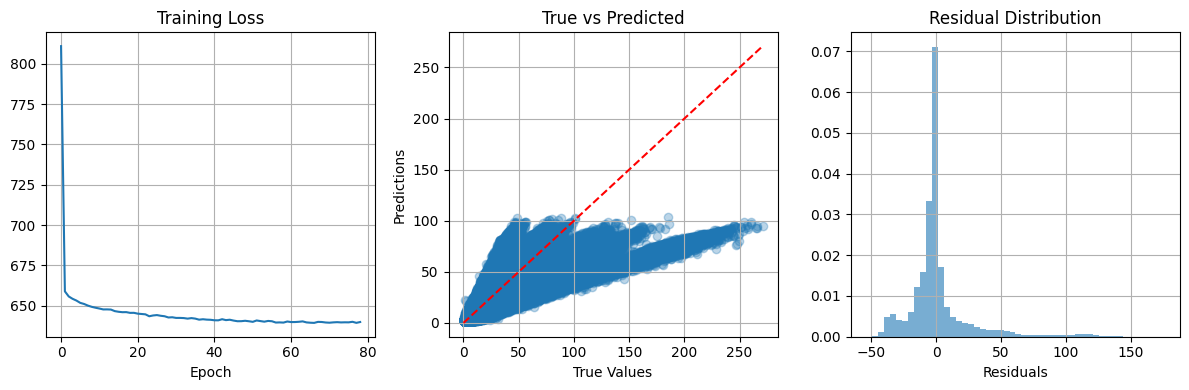

In [6]:
# Evaluación
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    # Métricas generales
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    
    print(f"\n📊 Test MSE: {mse:.4f}")
    print(f"📏 Test MAE: {mae:.4f}")
    print(f"📈 Test R2: {r2:.4f}")
    
    # Métricas por source
    test_df['pred'] = y_pred
    for col in test_df.filter(regex='^src_').columns:
        if test_df[col].sum() > 0:  # Solo para sources presentes en test
            source_name = col.replace('src_', '')
            subset = test_df[test_df[col] == 1]
            if not subset.empty:
                source_mae = mean_absolute_error(subset['Pmp (W)'], subset['pred'])
                print(f"MAE para {source_name}: {source_mae:.2f}")

# Gráficos
plt.figure(figsize=(12, 4))

# Pérdida de entrenamiento
plt.subplot(131)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.grid(True)

# Predicciones vs Reales
plt.subplot(132)
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([0, y_test_np.max()], [0, y_test_np.max()], 'r--')
plt.title('True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)

# Residuos
plt.subplot(133)
residuals = y_test_np - y_pred
plt.hist(residuals, bins=50, density=True, alpha=0.6)
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()